# Initial experiments: Raster, sequence pairs

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from dataset import QuickDrawDataset
from utils import AbsolutePenPositionTokenizer
from tqdm import tqdm
import pickle

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [ ]:
import pyvips
from io import BytesIO
from PIL import Image

def svg_rasterize(svg_string: str, size=(64, 64)) -> Image.Image:
    svg_bytes = svg_string.encode('utf-8')
    image = pyvips.Image.svgload_buffer(svg_bytes)
    image = image.flatten(background=0xFFFFFF)
    png_bytes = image.write_to_buffer(".png")
    img = Image.open(BytesIO(png_bytes)).convert("L")
    img = img.resize(size)
    tensor = torch.tensor(list(img.getdata()), dtype=torch.float32)
    tensor = tensor.view(size[1], size[0]) / 255.0
    return tensor

labels = ["cat"]

training_data = QuickDrawDataset(
    labels=labels,
    download=True
)

tokenizer = AbsolutePenPositionTokenizer(bins=64)

class SketchReconDataset(Dataset):
    def __init__(self, svg_list, tokenizer, max_len=200, cache_file="sketch-im_tokenized_dataset.pkl"):
        self.data = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_id = tokenizer.vocab["PAD"]
        
        # Try to load from cache
        try:
            with open(cache_file, "rb") as f:
                self.data = pickle.load(f)
            print(f"Loaded tokenized data from {cache_file}")
        except FileNotFoundError:
            for svg in tqdm(svg_list, desc="Tokenizing SVGs"):
                tokens = tokenizer.encode(svg)
                # Truncate + Pad
                tokens = tokens[:max_len]
                tokens = tokens + [self.pad_id] * (max_len - len(tokens))
                image = svg_rasterize(svg)
                self.data.append((tokens, image))

            # Save to cache
            with open(cache_file, "wb") as f:
                pickle.dump(self.data, f)
            print(f"Saved tokenized data to {cache_file}")

    def __getitem__(self, idx):
        seq, image = self.data[idx]
        input_ids = torch.tensor(seq[:-1])
        target_ids = torch.tensor(seq[1:])
        return image, input_ids, target_ids
    
    def __len__(self):
        return len(self.data)
    
dataset = SketchReconDataset(training_data, tokenizer, max_len=200)

Loading QuickDraw files: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Loaded tokenized data from sketch-im_tokenized_dataset.pkl


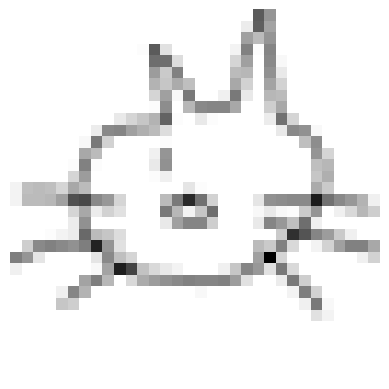

In [28]:
image, input_ids, target_ids = dataset[0]

image = (image * 255).byte()

# show image
image = image.numpy()

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()